# Free Troposphere Gradient
This looks at how the gradient of MSE and angular momentum in the free troposphere of the tropics vary throughout the year.

One would expect the angular momentum to remain constant, and the MSE gradient to not exceed a critical value.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use(os.environ['PWD']+'/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [2]:
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.constants import g, R, radius_earth, rot_earth
from isca_tools.utils import area_weighting, annual_time_slice
from isca_tools.utils.ds_slicing import annual_mean
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_scaling_factor_theory
from isca_tools.utils.circulation import get_u_thermal
from isca_tools.utils.constants import c_p

## Get datasets
Average into single year, so get annual mean seasonal cycle.

In [37]:
def get_angular_mom(u, lat, omega=7.2921150e-05, radius=radius_earth):
    cos_lat = np.cos(np.deg2rad(lat))
    return (u+omega*radius*cos_lat)*radius_earth*cos_lat

In [191]:
# Load dataset - at surface and in free troposphere
use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)
p_surface_approx = np.inf          # Desired approximate pressure of surface (hPa)

# Load dataset
# exp_dir = 'rossbypalooza/lat_20/'
# rot_rate = [0.25, 0.5, 1, 2, 4]
# exp_dir = 'rossbypalooza/lat_20/'
# rot_rate = [1]
# exp_dir = '/Users/joshduffield/Library/CloudStorage/OneDrive-UniversityofStAndrews/isca_output/rossbypalooza/sst_increase/'                # land with fixed SST
# rot_rate = ['zonal_land_SSTm2_1', 'zonal_land_SSTp1_1']
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
exp_names = [f"no_conv/k=1", f"no_conv/tau0=7_5"]
# exp_names = [f"k=1", f"tau_grad/tau0=7_5"]
# exp_dir = 'tau_sweep/aquaplanet/depth=1/ras_conv/'

# only keep variables required to compute relative humidity and MSE
var_keep = ['temp', 'sphum', 't_surf', 'precipitation', 'ucomp', 'vcomp', 'omega', 'height']

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']
# rot_rate = [1, 2]
n_exp = len(exp_names)
ds_base = []
ds = []
albedo = []
tau_sw = []
tau_lw = []
omega = []
time_start = 100
time_final = 9999999999999999
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for j in range(n_exp):
        namelist = isca_tools.load_namelist(exp_dir + exp_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        try:
            omega += [namelist['constants_nml']['omega']]
        except KeyError:
            omega += [7.2921150e-05]  # default earth value
        
        ds_base += [isca_tools.load_dataset(exp_dir + exp_names[j]).sel(time=slice(time_start, time_final))[var_keep]]
        
        # Compute thermal wind
        var_use = annual_mean(ds_base[j].temp.sel(pfull=slice(480, np.inf)).mean(dim='lon')).load()
        var_use = var_use[:, ::-1]      # invert pressure coordinate so 1st is surface
        var_use = var_use.transpose('pfull', 'lat', 'time')     # make time last axis
        var_use[:] = get_u_thermal(var_use, var_use.pfull*100, var_use.lat)     # keep time and lat info by setting each pfull to same array
        
        ds_use = ds_base[j].sel(pfull=[p_surface_approx, pressure_ft], method='nearest')      # only keep the surface and free troposphere values
        ds_use['ang_mom'] = get_angular_mom(ds_use.ucomp, ds_use.lat, omega[j])
        ds_use['mse_surf'] = moist_static_energy(ds_use.temp.isel(pfull=0), ds_use.sphum.isel(pfull=0), ds_use.height.isel(pfull=0))
        ds_use['mse_ft_sat'] = moist_static_energy(ds_use.temp.isel(pfull=1), sphum_sat(ds_use.temp.isel(pfull=1), ds_use.pfull.isel(pfull=1)*100),
                                               ds_use.height.isel(pfull=1))  
        ds_use = annual_mean(ds_use).mean(dim='lon')        # only keep annual mean
        ds_use['u_thermal'] = var_use.isel(pfull=0).transpose('time', 'lat')     # all pressure levels of var_use are the same
        ds_use['ang_mom_thermal'] = get_angular_mom(ds_use.u_thermal, ds_use.lat, omega[j])
        ds_use['ang_mom_u0'] = get_angular_mom(0, ds_use.lat, omega[j])
        ds += [ds_use.load()]          
        pbar.update(1)
pfull = ds_base[0].pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size

  0%|          | 0/2 [00:00<?, ?it/s]/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 25 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
 50%|█████     | 1/2 [00:29<00:29, 29.76s/it]/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 25 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
100%|██████████| 2/2 [00:58<00:00, 29.46s/it]


In [192]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05
im_sz = 1.5

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

Text(0, 0.5, '$u$ [m/s]')

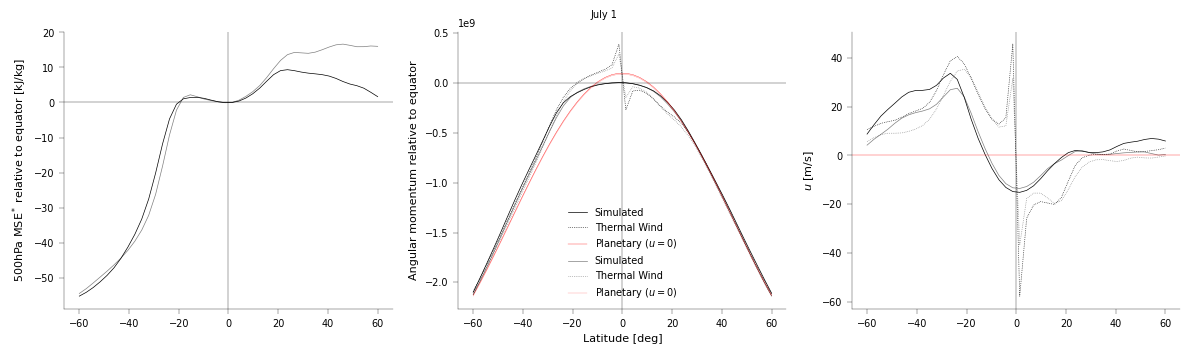

In [257]:
month_names = ['January','February','March','April','May','June','July','August','September','October','November','December']
plot_day = int(30*6)
plot_exp = 0
ind_eq = int(np.abs(ds[0].lat).argmin())
plot_lat = slice(-60, 60)

fig, ax = plt.subplots(1, 3, figsize=(im_sz*3*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
fig.suptitle(f'{month_names[int(np.floor(plot_day/30))]} {plot_day%30+1}', fontsize=7, y=0.94)
for plot_exp in range(n_exp):
    ds_use = ds[plot_exp].sel(lat=plot_lat)
    
    ax[0].plot(ds_use.lat, ds_use.mse_ft_sat[plot_day]-ds_use.mse_ft_sat[plot_day].sel(lat=0, method='nearest'), color='k', 
               alpha=-0.5*plot_exp+1)
    ax[1].plot(ds_use.lat, ds_use.ang_mom[plot_day, ind_ft]-ds_use.ang_mom[plot_day, ind_ft].sel(lat=0, method='nearest'), color='k', 
               label='Simulated', alpha=-0.5*plot_exp+1)
    ax[1].plot(ds_use.lat, ds_use.ang_mom_thermal[plot_day]-ds_use.ang_mom[plot_day, ind_ft].sel(lat=0, method='nearest'), 
               linestyle=':', color='k', label='Thermal Wind', alpha=-0.5*plot_exp+1)
    ax[1].plot(ds_use.lat, ds_use.ang_mom_u0-ds_use.ang_mom[plot_day, ind_ft].sel(lat=0, method='nearest'), lw=ax_linewidth, color='r', 
               label='Planetary ($u=0$)', alpha=-0.5*plot_exp+1)
    ax[2].plot(ds_use.lat, ds_use.ucomp[plot_day, ind_ft], color='k', alpha=-0.5*plot_exp+1)
    ax[2].plot(ds_use.lat, ds_use.u_thermal[plot_day], color='k', linestyle=':', alpha=-0.5*plot_exp+1)
for i in range(len(ax)):
    ax[i].axvline(0, color='k', lw=ax_linewidth)
    ax[i].axhline(0, color='r' if i==2 else 'k', lw=ax_linewidth)
ax[1].legend()
ax[1].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('500hPa MSE$^*$ relative to equator [kJ/kg]')
ax[1].set_ylabel('Angular momentum relative to equator')
ax[2].set_ylabel('$u$ [m/s]')
# ax[0].set_ylim(0, 8)
# ax[1].set_ylim(-3e8, 4e8)
# ax[0].set_xlim(-20, 20)
# ax[0].set_ylim(320, 335)
# ax[1].set_ylim(2.5e9, 3.3e9)s

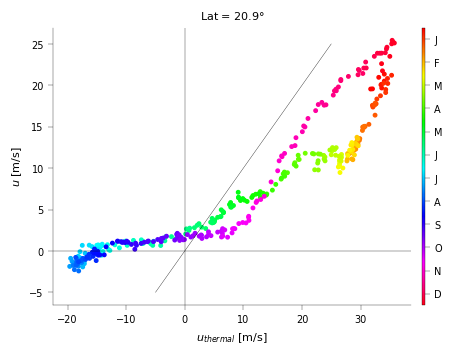

In [258]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

plot_lat_ind = 39
fig, ax = plt.subplots(1, 1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
im = ax.scatter(ds[plot_exp].u_thermal.isel(lat=plot_lat_ind), ds[plot_exp].ucomp.isel(lat=plot_lat_ind, pfull=ind_ft), 
                c=ds[plot_exp].time, cmap='hsv')
ax.plot([-5, 25], [-5, 25], color='k', lw=ax_linewidth)
ax.axvline(0, color='k', lw=ax_linewidth)
ax.axhline(0, color='k', lw=ax_linewidth)

cbar = fig.colorbar(im, ax=ax, aspect=100, pad=0.03, fraction=0.01)
cbar.ax.invert_yaxis()
cbar.ax.set_yticks(*month_ticks)
ax.set_xlabel('$u_{thermal}$ [m/s]')
ax.set_ylabel('$u$ [m/s]')
ax.set_title(f'Lat = {round(float(ds[plot_exp].lat[plot_lat_ind]), 1)}$\degree$');

Text(0, 0.5, '$T_s$ Relative to Equator')

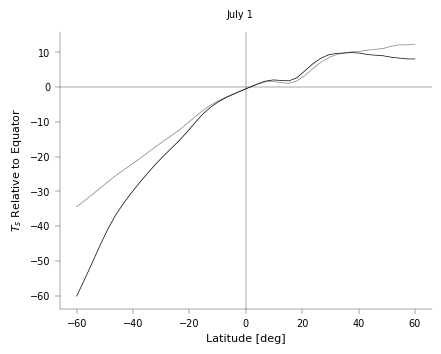

In [263]:
fig, ax = plt.subplots(1, 1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
fig.suptitle(f'{month_names[int(np.floor(plot_day/30))]} {plot_day%30+1}', fontsize=7, y=0.94)
for plot_exp in range(n_exp):
    ds_use = ds[plot_exp].sel(lat=plot_lat)
    ax.plot(ds_use.lat, ds_use.t_surf[plot_day]-ds_use.t_surf[plot_day].sel(lat=0, method='nearest'), color='k', 
               alpha=-0.5*plot_exp+1)
ax.axvline(0, color='k', lw=ax_linewidth)
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('$T_s$ Relative to Equator')